In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso, Ridge, RidgeCV, LinearRegression
from BayesianLasso import BayesianLasso

In [2]:
"""

In this notebook, we apply the PulseCV and PulseMML BLasso methods to the dataset. We also calculate OLS estimates and 
Lasso estimates with lambda chosen by cross-validation. 

Finally, we treat the dataset from a ML perspective & use the data/feature engineering to try and optimise predictions.

"""

print(" ")

In [3]:
# Input dataset
dataset = pd.read_csv("Data/efron_diabetesData.txt",sep="\t")
dataset.shape

(442, 11)

In [4]:
# Shuffle dataset
# Split into training, validation and test sets
# DO NOT LOOK AT THE TEST SET (X_test,y_test)

data = dataset.sample(frac=1,random_state=1,axis=0) # Re-running this line of code alone will produce a different shuffle. Run previous block first.

X = data.iloc[:,:-1]
y = data.iloc[:,-1]

X_training = X[:360]
X_valid = X[360:400]
X_test = X[400:]

y_training = y[:360]
y_valid = y[360:400]
y_test = y[400:]

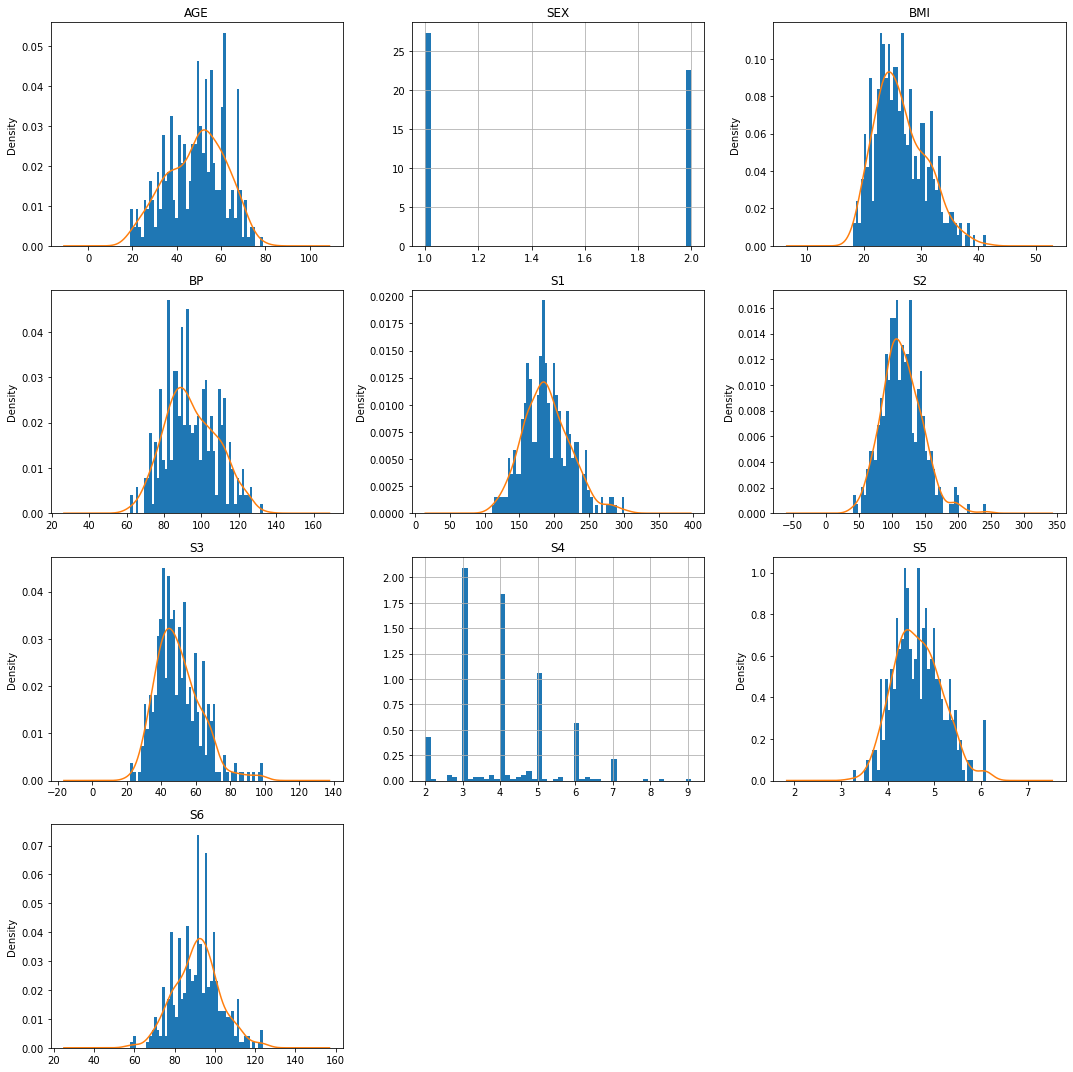

In [5]:
# Need to standardise the training set. Visualise the data.

"""Histograms with superimposed KDEs"""

ax = X_training.hist(bins=50, figsize=(15,15),density=True)

for row in range(3):
    for col in range(3):
        if ((X_training.columns[3*row + col]=="SEX") or (X_training.columns[3*row + col]== "S4")):
            pass
        else:
            X_training[X_training.columns[3*row + col]].plot(kind="kde",ax=ax[row][col])
        
X_training["S6"].plot(kind="kde",ax=ax[3][0])

plt.tight_layout()
plt.show()

# Normalise Sex instead of standardising it. Further suspicions on S4; this needs to be cleaned up, but for now standardise it.

In [6]:
# Create a Pipeline for easy processing of validation and test sets later

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

num_attribs = list(X_training.columns)
num_attribs.remove("SEX")
cat_attribs = ["SEX"]
    
num_pipeline = Pipeline([
    ("standardiser", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("normaliser", MinMaxScaler()),
])

processingPipeline = ColumnTransformer([
    ("numeric",num_pipeline,num_attribs),
    ("categoric",cat_pipeline,cat_attribs),
])

X_trainNP = processingPipeline.fit_transform(X_training)
X_trainNP

array([[ 0.85847115, -0.68605734, -1.29581873, ...,  0.95501932,
        -1.26628213,  0.        ],
       [-1.67598146, -0.86860031, -1.704226  , ..., -0.44375711,
        -1.08900756,  0.        ],
       [-1.52237827,  1.96081576,  0.26434027, ..., -1.17670035,
        -0.02536011,  0.        ],
       ...,
       [-0.98476711,  2.8963485 , -0.33566548, ...,  1.51043306,
         1.03828733,  1.        ],
       [-1.1383703 , -1.32495774,  0.24057053, ..., -1.8676998 ,
         0.06327717,  1.        ],
       [ 1.47288391, -0.36660714,  0.45665903, ..., -1.51205553,
        -0.37990926,  1.        ]])

In [7]:
# Print the preprocessed training set

X_train = pd.DataFrame(X_trainNP, columns = num_attribs + cat_attribs)
y_train = y_training - np.mean(y_training)
X_train

,AGE,BMI,BP,S1,S2,S3,S4,S5,S6,SEX
0,0.858471,-0.686057,-1.295819,1.696269,1.085481,1.149586,-0.203990,0.955019,-1.266282,0.0
1,-1.675981,-0.868600,-1.704226,-2.154138,-2.398717,0.462316,-1.623352,-0.443757,-1.089008,0.0
2,-1.522378,1.960816,0.264340,0.432395,0.905608,0.004136,0.016800,-1.176700,-0.025360,0.0
3,-0.523958,-1.393411,-1.704226,-0.831479,-1.139609,1.225950,-1.623352,-0.804083,-0.911733,0.0
4,0.781670,0.112568,0.672748,0.138471,0.372653,-0.530407,0.742252,0.307719,1.304199,1.0
...,...,...,...,...,...,...,...,...,...,...
355,0.474463,0.409200,-0.263636,1.784447,0.825665,1.302313,-0.046283,1.404110,1.038287,0.0
356,-0.677561,0.112568,-0.191606,0.403003,0.146146,1.531403,-0.834817,-0.890702,-0.911733,0.0
357,-0.984767,2.896348,-0.335665,0.873281,0.679102,-0.912224,1.530786,1.510433,1.038287,1.0
358,-1.138370,-1.324958,0.240571,-0.184846,-0.779864,2.524126,-1.623352,-1.867700,0.063277,1.0


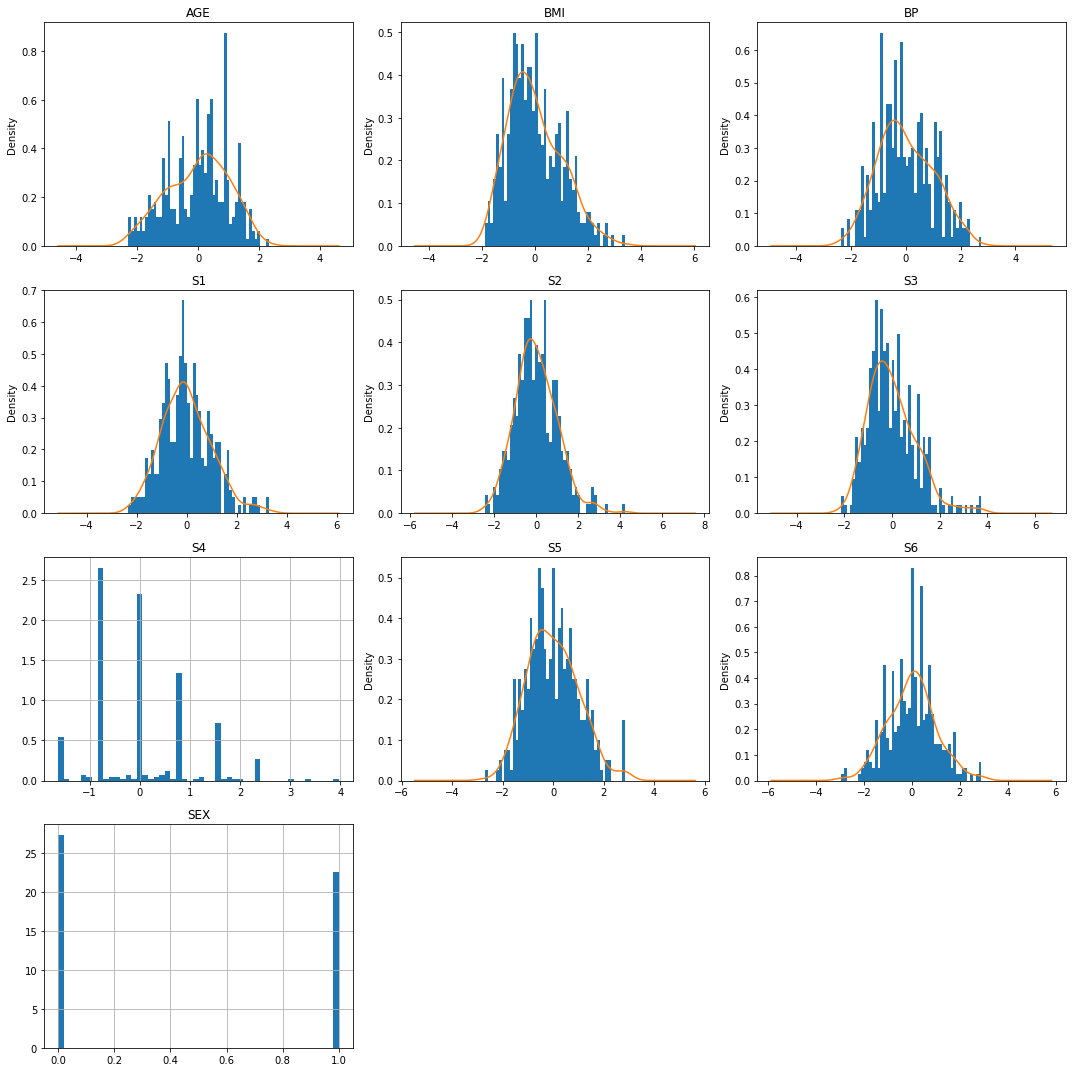

In [8]:
# See plots now

"""Histograms with superimposed KDEs"""

ax = X_train.hist(bins=50, figsize=(15,15),density=True)

for row in range(3):
    for col in range(3):
        if ((X_train.columns[3*row + col]=="SEX") or (X_train.columns[3*row + col]== "S4")):
            pass
        else:
            X_train[X_train.columns[3*row + col]].plot(kind="kde",ax=ax[row][col])
        

plt.tight_layout()
plt.show()

In [9]:
""" 
Having processed the dataset, create a linear regression model and determine OLS and Lasso estimates.
For the Lasso estimates, choose lambda by 10-fold cross-validation.
"""
print(" ")

In [10]:
# Now create Linear Regression Model

linearModel = LinearRegression(fit_intercept=False)
linearModel.fit(X_train,y_train)
print(linearModel.coef_)

[  0.50602537  25.36289367  16.42643622 -39.38809774  25.34118414
   4.51406888   4.75430312  33.72826083   1.92098546  -9.93486808]


In [11]:
# Now create a Lasso Regression Model with lambda chosen by cross-validation

lassoModel = LassoCV(cv=10,fit_intercept=False,max_iter=100000,alphas=np.linspace(0.0005,10,5000))
lassoModel.fit(X_train,y_train)

print("Smallest lambda tested in CV is:",min(lassoModel.alphas_)*2*X_train.shape[0])
print("Largest lambda tested in CV is:",max(lassoModel.alphas_)*2*X_train.shape[0])
print("Number of lambdas tested in CV is:", len(lassoModel.alphas_))
print("Lambda chosen by cross-validation is:", lassoModel.alpha_*2*X_train.shape[0])
print("Relative L1 Norm of Betas chosen by lambda_CV:", np.linalg.norm(lassoModel.coef_,1)/np.linalg.norm(linearModel.coef_,1))

Smallest lambda tested in CV is: 0.36
Largest lambda tested in CV is: 7200.0
Number of lambdas tested in CV is: 5000
Lambda chosen by cross-validation is: 390.65854770954184
Relative L1 Norm of Betas chosen by lambda_CV: 0.5521622564141568


In [12]:
# Return Lasso estimates when lambda is chosen by cross-validation
print(lassoModel.coef_)

[ 0.09113911 25.66785059 15.96128576 -6.59492726  0.         -9.91204613
  0.         21.78071641  1.49897038 -7.87550213]


In [13]:
""" 
Now assume a Bayesian setting and place iid Laplace priors on the Beta as in Park & Casella. 
Place a Pulse Prior centred at lambdaMML^2 on lambda^2.
"""
print(" ")

In [14]:
# Now find the Maximum Marginal Likelihood estimate for lambda

bayesianLasso = BayesianLasso(X_train.values,np.reshape(y_train.values,(-1,1)))
lambdasMML,lambdaMML = bayesianLasso.lambda_MML(gibbs_iter=7500,em_iter=30)

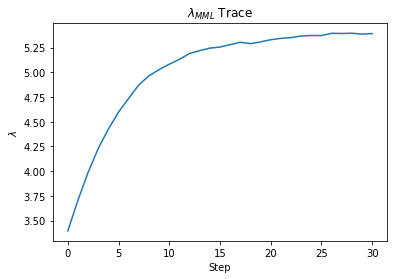

In [15]:
# Trace of the EM algorithm for lambdaMML

plt.title(fr"$\lambda_{{MML}}$ Trace")
plt.ylabel(r"$\lambda$")
plt.xlabel("Step")
plt.plot(lambdasMML)
plt.show()

In [16]:
# Run the Gibbs Sampler using the squared MML estimate for lambda as the mode of the Pulse Prior.

N = 50000
betaTracesPulseMML, sig2TracesPulseMML, tau2TracesPulseMML, lambdaTracesPulseMML = bayesianLasso.gibbs_gammaHPrior(r=1+(lambdaMML)**4,delta=lambdaMML**2,n_iter=N) 

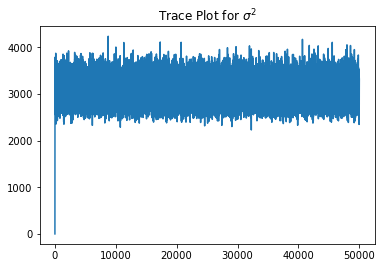

In [17]:
# Trace plot for Sigma^2

plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2TracesPulseMML)
plt.show()

# Use burn-in of 2500

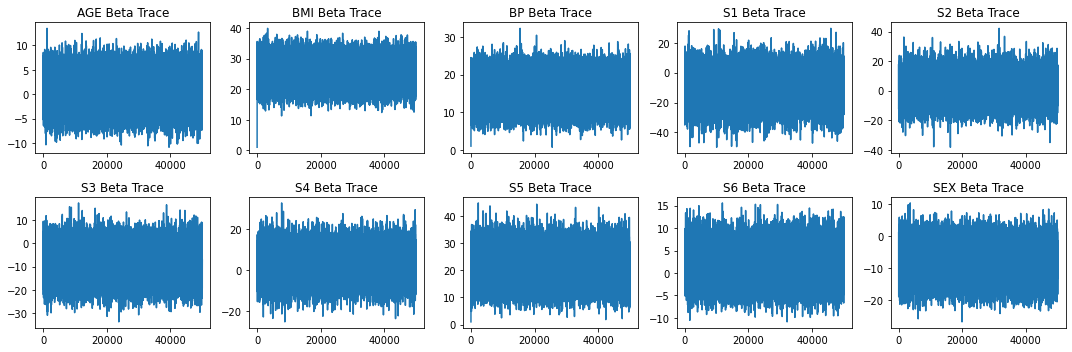

In [18]:
# Trace Plots for the Beta

figBetaTracesMML, axBetaTracesMML = plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i in range(1,3):
    for j in range(1,6):
        axBetaTracesMML[i-1][j-1].plot(betaTracesPulseMML[:,5*(i-1)+j-1])
        axBetaTracesMML[i-1][j-1].title.set_text(f"{(num_attribs+cat_attribs)[5*(i-1)+j-1]} Beta Trace")

plt.tight_layout()
plt.show()

# burn in 2500 suitable

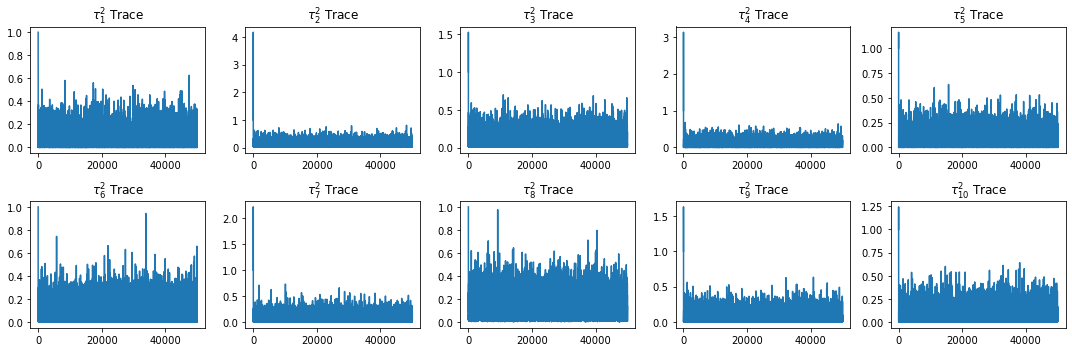

In [19]:
# Trace Plots for the Tau^2

figTau2TracesMML, axTau2TracesMML = plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i in range(1,3):
    for j in range(1,6):
        axTau2TracesMML[i-1][j-1].plot(tau2TracesPulseMML[:,5*(i-1)+j-1])
        axTau2TracesMML[i-1][j-1].title.set_text(fr"$\tau^{2}_{{{5*(i-1)+j}}}$ Trace")

plt.tight_layout()
plt.show()

# burn in 2500 suitable

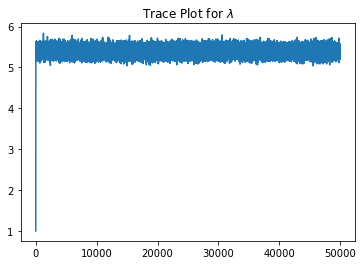

In [20]:
# Trace plot for Lambdas

plt.title(r"Trace Plot for $\lambda$")
plt.plot(lambdaTracesPulseMML)
plt.show()

# Use burn-in of 2000

In [21]:
burned_BetaPulseMML = betaTracesPulseMML[2000:,:]
burned_Sig2PulseMML = sig2TracesPulseMML[2000:]
burned_Tau2PulseMML = tau2TracesPulseMML[2000:,:]
burned_LambdaPulseMML = lambdaTracesPulseMML[2000:]

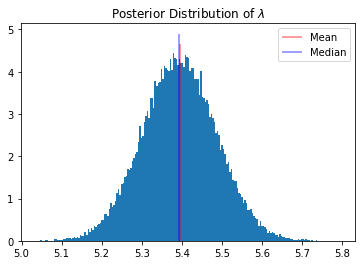

Mean: 5.394313630991301
Median: 5.39396447413763


In [22]:
# Histogram for Lambda

plt.title(r"Posterior Distribution of $\lambda$")
plt.hist(burned_LambdaPulseMML,bins=200,density=True)
plt.vlines(np.mean(burned_LambdaPulseMML),0,plt.gca().get_ylim()[1],colors="r",label="Mean",alpha=0.5)
plt.vlines(np.median(burned_LambdaPulseMML),0,plt.gca().get_ylim()[1],colors="b",label="Median",alpha=0.5)
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(burned_LambdaPulseMML)}")
print(f"Median: {np.median(burned_LambdaPulseMML)}")

# Mode roughly the MML estimate

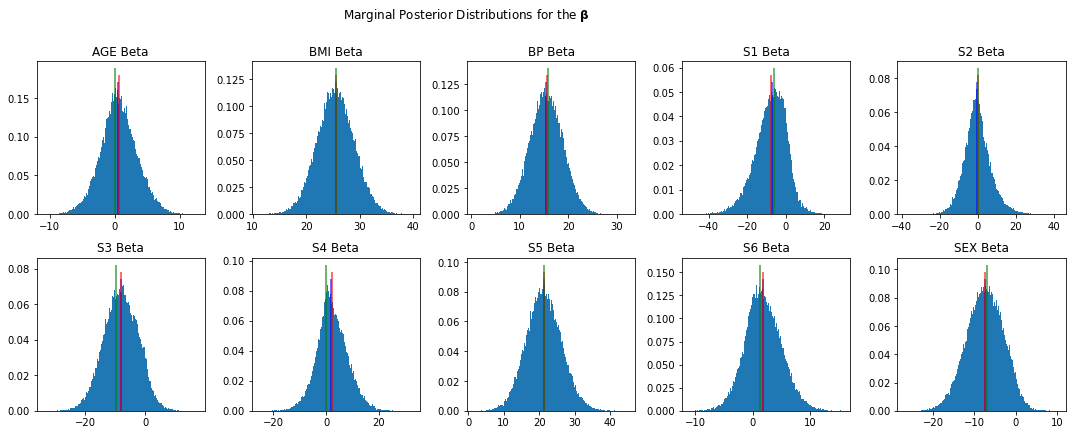

In [23]:
# Histograms for Beta with superimposed mean & median estimates, as well as approximate Modes via. frequentist Lasso.

sigmamedianMML = np.median(np.sqrt(burned_Sig2PulseMML))
lambdamedianMML = np.median(burned_LambdaPulseMML)

_,lassoModes = bayesianLasso.lasso(2*sigmamedianMML*lambdamedianMML,steps=1000)

figBetaHistMML, axBetaHistMML = plt.subplots(nrows=2,ncols=5,figsize=(15,6))

for i in range(1, 3):
    for j in range(1, 6):
        axBetaHistMML[i-1][j-1].hist(burned_BetaPulseMML[:,5*(i-1)+j-1],bins=200,density=True)
        axBetaHistMML[i-1][j-1].title.set_text(f"{(num_attribs+cat_attribs)[5*(i-1)+j-1]} Beta")
        axBetaHistMML[i-1][j-1].vlines(np.median(burned_BetaPulseMML,axis=0)[5*(i-1)+j-1],0,axBetaHistMML[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.75)
        axBetaHistMML[i-1][j-1].vlines(np.mean(burned_BetaPulseMML,axis=0)[5*(i-1)+j-1],0,axBetaHistMML[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.75)
        axBetaHistMML[i-1][j-1].vlines(lassoModes[5*(i-1)+j-1],0,axBetaHistMML[i-1][j-1].get_ylim()[1],colors="g",label="Mode Estimate",alpha=0.75)

figBetaHistMML.suptitle(r"Marginal Posterior Distributions for the $\mathbf{\beta}$",x=0.435,y=1.0)
plt.tight_layout()
plt.show()

# The symmetric distributions mean that the mode, mean and medians are really close
# But it does look like the frequentist estimates match the empirical mode of the posteriors.

In [24]:
""" 
Continue the Bayesian setting with iid Laplace priors on the Beta as in Park & Casella. 
Place a Pulse Prior centred at lambdaCV^2 on lambda^2.
"""
print(" ")

In [25]:
# Compute rescaled lambdaCV

lambdaCV = lassoModel.alpha_ * 2 * X_train.shape[0]

smLinearModel = sm.OLS(y_train.values,X_train.values).fit()
s2 = np.sum(smLinearModel.resid**2)/(X_train.shape[0]-X_train.shape[1])
lam_rescaledCV = lambdaCV/(2*np.sqrt(s2))

print("Rescaled Lambda chosen by Cross-Validation:", lam_rescaledCV)

Rescaled Lambda chosen by Cross-Validation: 3.553276625769635


In [27]:
# Run the Gibbs Sampler using the rescaled CV estimate for lambda as nu in the defined Pulse Prior

betaTracesPulseCV, sig2TracesPulseCV, tau2TracesPulseCV, lambdaTracesPulseCV = bayesianLasso.gibbs_gammaHPrior(r = 1+(lam_rescaledCV**4), delta = lam_rescaledCV**2, n_iter=30000)

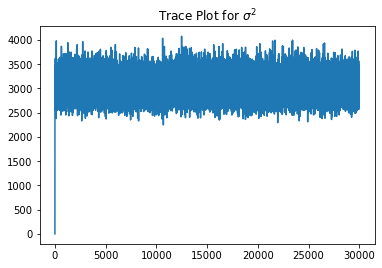

In [28]:
# Trace plot for Sigma^2

plt.title(r"Trace Plot for $\sigma^{2}$")
plt.plot(sig2TracesPulseCV)
plt.show()

# A burn in period of 5000 seems sufficient

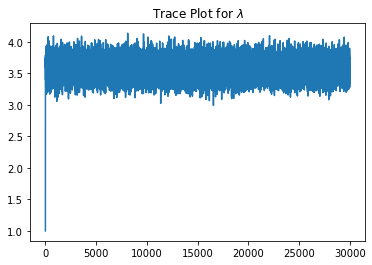

In [29]:
# Trace plot for Lambda

plt.title(r"Trace Plot for $\lambda$")
plt.plot(lambdaTracesPulseCV)
plt.show()

# A burn in period of 5000 seems sufficient

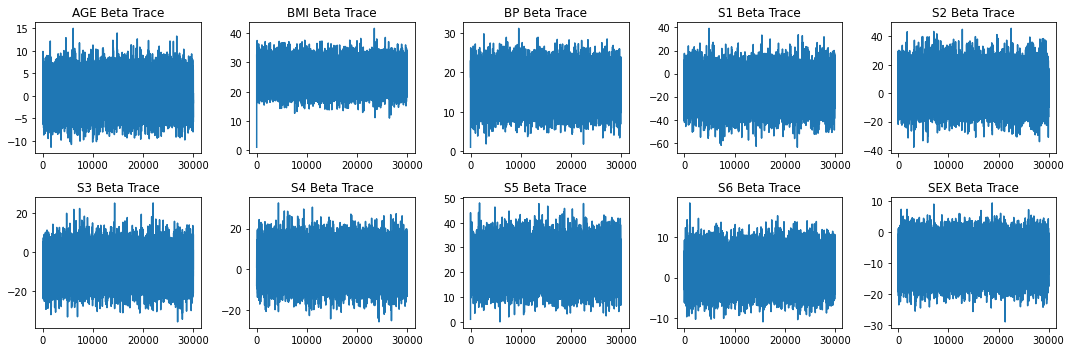

In [30]:
# Trace Plots for the Beta

figBetaTracesCV, axBetaTracesCV = plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i in range(1,3):
    for j in range(1,6):
        axBetaTracesCV[i-1][j-1].plot(betaTracesPulseCV[:,5*(i-1)+j-1])
        axBetaTracesCV[i-1][j-1].title.set_text(f"{(num_attribs+cat_attribs)[5*(i-1)+j-1]} Beta Trace")

plt.tight_layout()
plt.show()

# burn in 5000 suitable

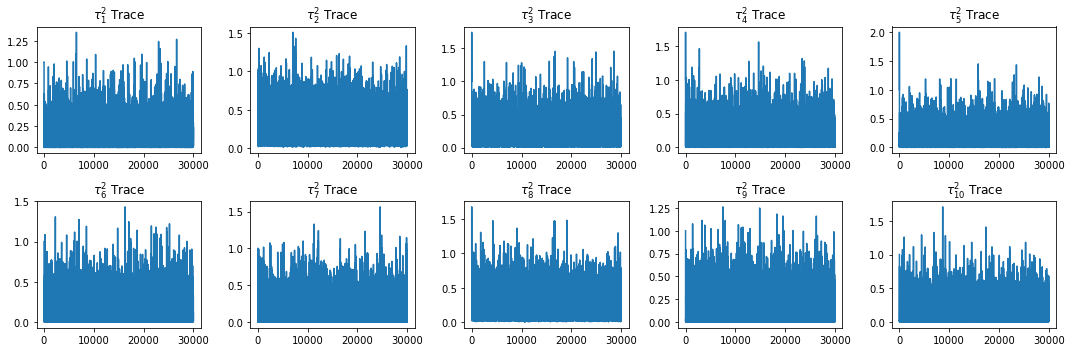

In [31]:
# Trace Plots for the Tau^2

figTau2TracesCV, axTau2TracesCV = plt.subplots(nrows=2,ncols=5,figsize=(15,5))

for i in range(1,3):
    for j in range(1,6):
        axTau2TracesCV[i-1][j-1].plot(tau2TracesPulseCV[:,5*(i-1)+j-1])
        axTau2TracesCV[i-1][j-1].title.set_text(fr"$\tau^{2}_{{{5*(i-1)+j}}}$ Trace")

plt.tight_layout()
plt.show()

# burn in 5000 suitable

In [32]:
burned_BetaPulseCV = betaTracesPulseCV[5000:,:]
burned_Sig2PulseCV = sig2TracesPulseCV[5000:]
burned_Tau2PulseCV = tau2TracesPulseCV[5000:,:]
burned_LambdaPulseCV = lambdaTracesPulseCV[5000:]

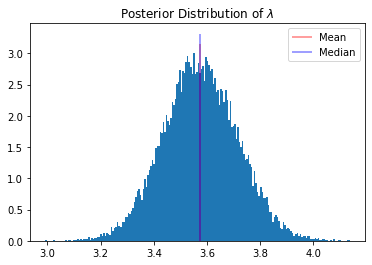

Mean: 3.5756244261428933
Median: 3.573616488476055


In [33]:
# Histogram for Lambda

plt.title(r"Posterior Distribution of $\lambda$")
plt.hist(burned_LambdaPulseCV,bins=200,density=True)
plt.vlines(np.mean(burned_LambdaPulseCV),0,plt.gca().get_ylim()[1],colors="r",label="Mean",alpha=0.5)
plt.vlines(np.median(burned_LambdaPulseCV),0,plt.gca().get_ylim()[1],colors="b",label="Median",alpha=0.5)
plt.legend(loc="upper right")
plt.show()

print(f"Mean: {np.mean(burned_LambdaPulseCV)}")
print(f"Median: {np.median(burned_LambdaPulseCV)}")

# Mode appears to agree with the rescaled lambdaCV. Note that it's similar in size to (but slghtly larger than) lambdaMML.

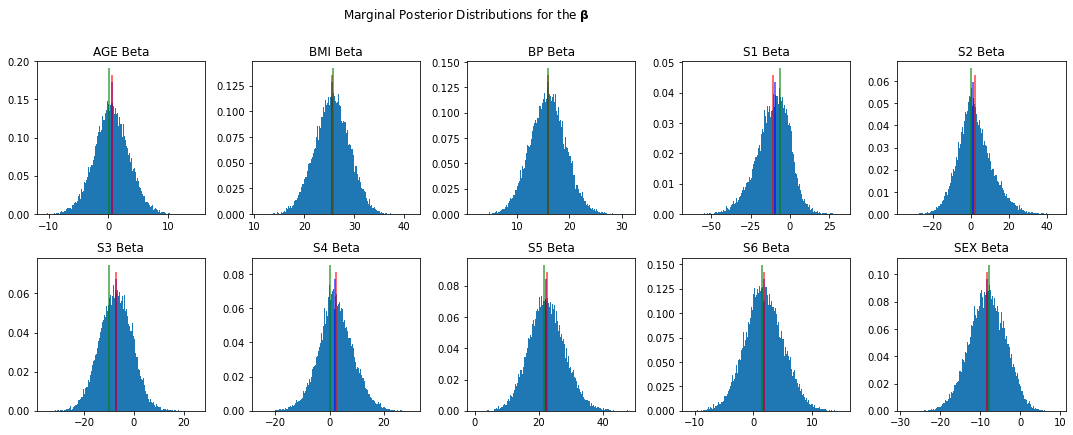

In [35]:
# Histograms for Beta in the PulseCV case.

sigmamedianCV = np.median(np.sqrt(burned_Sig2PulseCV))
lambdamedianCV = np.median(burned_LambdaPulseCV)

_,lassoModesCV = bayesianLasso.lasso(2*sigmamedianCV*lambdamedianCV,steps=1000)

figCV, axCV = plt.subplots(nrows=2,ncols=5,figsize=(15,6))

for i in range(1, 3):
    for j in range(1, 6):
        axCV[i-1][j-1].hist(burned_BetaPulseCV[:,5*(i-1)+j-1],bins=200,density=True)
        axCV[i-1][j-1].title.set_text(f"{(num_attribs+cat_attribs)[5*(i-1)+j-1]} Beta")
        axCV[i-1][j-1].vlines(np.median(burned_BetaPulseCV,axis=0)[5*(i-1)+j-1],0,axCV[i-1][j-1].get_ylim()[1],colors="b",label="Median",alpha=0.75)
        axCV[i-1][j-1].vlines(np.mean(burned_BetaPulseCV,axis=0)[5*(i-1)+j-1],0,axCV[i-1][j-1].get_ylim()[1],colors="r",label="Mean",alpha=0.75)
        axCV[i-1][j-1].vlines(lassoModesCV[5*(i-1)+j-1],0,axCV[i-1][j-1].get_ylim()[1],colors="g",label="Mode Estimate",alpha=0.75)

figCV.suptitle(r"Marginal Posterior Distributions for the $\mathbf{\beta}$",x=0.435,y=1.0)
plt.tight_layout()
plt.show()

# Approximate modes very close to the actual modes.

In [36]:
""" 
Make 2 plots, each corresponding to one of the Bayesian models.
For each predictor, plot the OLS estimate, Lasso estimate and posterior median estimate. Superimpose 95% equitailed intervals.
"""

print(" ")

In [37]:
# Compile the posterior medians and equitailed intervals in one place

betaPosteriorMediansMML = np.median(burned_BetaPulseMML,axis=0)
betaPosteriorMediansCV = np.median(burned_BetaPulseCV,axis=0)
beta95EquitailedMML = np.quantile(burned_BetaPulseMML,[0.025,0.975],axis=0).T
beta95EquitailedCV = np.quantile(burned_BetaPulseCV,[0.025,0.975],axis=0).T

print(beta95EquitailedMML.shape,beta95EquitailedCV.shape)

(10, 2) (10, 2)


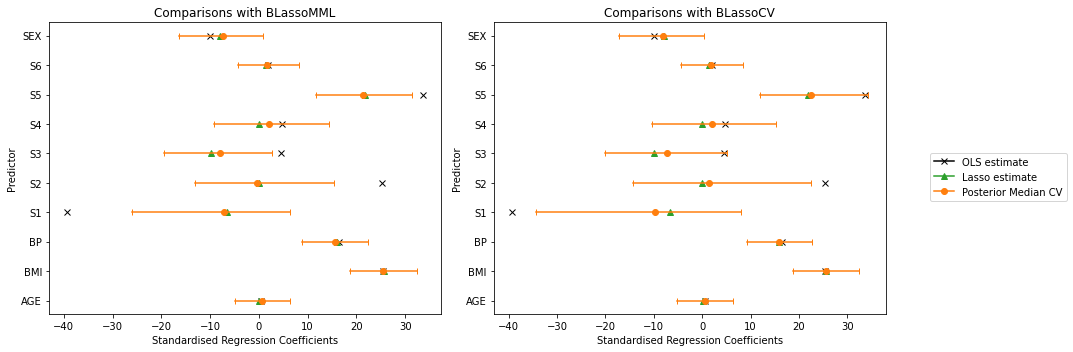

In [38]:
# We now have OLS, Lasso (CV) and two Bayesian Lasso estimates.
# Make two plots with x-axis coefficients and y-axis variable number.
# For each predictor, plot posterior median & equitailed intervals, OLS estimates, Lasso estimates with lambda chosen by CV

figResults, axResults = plt.subplots(nrows=1,ncols=2,figsize=(15,5))

axResults[0].set_xlabel("Standardised Regression Coefficients")
axResults[0].set_ylabel("Predictor")
axResults[0].set_yticks(np.linspace(1,11,11))
axResults[0].set_yticklabels(num_attribs + cat_attribs + [""])

axResults[1].set_xlabel("Standardised Regression Coefficients")
axResults[1].set_ylabel("Predictor")
axResults[1].set_yticks(np.linspace(1,11,11))
axResults[1].set_yticklabels(num_attribs + cat_attribs + [""])

for pred in range(1,11):
    # Plot OLS estimates
    axResults[0].plot(linearModel.coef_[pred-1],pred,marker="x",color="black",label="OLS estimate")
    axResults[1].plot(linearModel.coef_[pred-1],pred,marker="x",color="black",label="OLS estimate")
    # Plot Lasso estimates based on 10 fold cross-validation
    axResults[0].plot(lassoModel.coef_[pred-1],pred,marker="^",color="tab:green",label="Lasso estimate")
    axResults[1].plot(lassoModel.coef_[pred-1],pred,marker="^",color="tab:green",label="Lasso estimate")
    # Plot Posterior median estimates
    axResults[0].plot(betaPosteriorMediansMML[pred-1],pred,marker="o",color="tab:orange",label="Posterior Median MML")
    axResults[1].plot(betaPosteriorMediansCV[pred-1],pred,marker="o",color="tab:orange",label="Posterior Median CV")
    # Plot Equitailed Intervals
    axResults[0].plot(beta95EquitailedMML[pred-1],(pred,pred),marker="|",color="tab:orange")
    axResults[1].plot(beta95EquitailedCV[pred-1],(pred,pred),marker="|",color="tab:orange")
    # Set titles
    axResults[0].title.set_text("Comparisons with BLassoMML")
    axResults[1].title.set_text("Comparisons with BLassoCV")
    
    if pred == 10:
        handles, labels = axResults[1].get_legend_handles_labels()
        legdict = dict(zip(labels, handles))
        axResults[1].legend(legdict.values(),legdict.keys(),bbox_to_anchor=(1.1, 0.57))
        
plt.tight_layout()
plt.show()

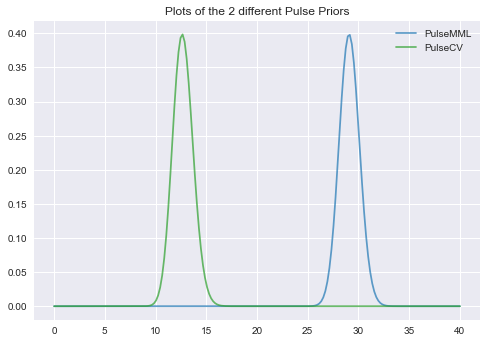

5.39185100715626 3.553276625769635


In [47]:
# Interestingly, BLassoCV seems to result in wider/less certain posterior distributions.
# We finally plot the two different Gamma distributions used.
# Not surprising because in this case, the PulseMML places greater weight on larger lambda than PulseCV.
# The stricter the regularisation, the smaller the uncertainty, justifying the above observation.
# However, the results from both methods are similar.
plt.style.use("seaborn")
domain = np.linspace(0,40,200)
pulsemml = stats.gamma.pdf(domain,1+lambdaMML**4,scale=1/(lambdaMML**2))
pulsecv = stats.gamma.pdf(domain,1+lam_rescaledCV**4,scale=1/(lam_rescaledCV**2))

plt.title("Plots of the 2 different Pulse Priors")
plt.plot(domain,pulsemml,color="tab:blue",label="PulseMML",alpha=0.7)
plt.plot(domain,pulsecv,color="tab:green",label="PulseCV",alpha=0.7)

plt.legend()
plt.show()

print(lambdaMML,lam_rescaledCV)

In [ ]:
"""----------------------------------------------------------------------------------------------------------------"""
""" Modern ML bit - DO LATER"""
"""----------------------------------------------------------------------------------------------------------------"""

In [ ]:
X_training.head()
# Age, Sex, S1, S3, S6 seem like integers - discrete predictors.

In [ ]:
X_training.info()
# 360 entries, 10 columns
# No null values - good.
# Age, Sex, S1, S6 are discrete - look at the data a bit further. 
# What can be standardised?

In [ ]:
X_training["SEX"].value_counts() # 197 '1' and 163 '2'

In [ ]:
X_training.describe()

In [ ]:
"""Histograms with superimposed KDEs"""

ax = X_training.hist(bins=50, figsize=(15,15),density=True)

for row in range(3):
    for col in range(3):
        if ((X_training.columns[3*row + col]=="SEX") or (X_training.columns[3*row + col]== "S4")):
            pass
        else:
            X_training[X_training.columns[3*row + col]].plot(kind="kde",ax=ax[row][col])
        
X_training["S6"].plot(kind="kde",ax=ax[3][0])

plt.tight_layout()
plt.show()

In [ ]:
# (1) Possible clusters in Age, BMI, BP, S1, S3? Could add predictors giving proximity to each cluster mode?
# (2) S4 interesting. Appear to be definitive groups in the data.
#     Could introduce discrete predictors grouping S4 (<=2, 2<x<=3, 3<x<=4, 4<x<=5, 5<x<=6, 6<x<=7, >7)

# Return to later. Proceed with EDA

In [ ]:
corr = X_training.corr()
corr

# Potential collinearity (S1,S2), (S3,S4), (S2, S4... maybe?), (S5,S4... maybe?)

In [ ]:
# VIFS
from statsmodels.stats.outliers_influence import variance_inflation_factor
vifs = pd.DataFrame()
vifs["Predictor"] = [X_training.columns[i-1] for i in range(1,X_training.shape[1]+1)]
vifs["VIF"] = [variance_inflation_factor(X_training.values,i) for i in range(0,10)]
vifs



In [ ]:
# Try to get an idea of correlation with the predictor
pd.concat([X_training,y_training],axis=1).corr()["Y"].sort_values(ascending=False)

In [ ]:
# BMI, S5, BP, S4, S6, S3 look like promising predictors
promPred = ["BMI", "S5", "BP", "S4", "S6", "S3"]

corrfig, corrax = plt.subplots(nrows=1,ncols=6,figsize=(20,3))

for col in range(6):
    corrax[col].title.set_text(f"Y vs {promPred[col]}")
    corrax[col].scatter(X_training[promPred[col]],y_training)
    
plt.tight_layout()
plt.show()

In [ ]:
# Potentially try a log transform on S3?
stats.pearsonr(np.log(X_training["S3"]),y_training)
# Returns a Pearson's R of -0.4; not too dissimilar to before.

In [ ]:
from sklearn.neighbors.kde import KernelDensity
from scipy.signal import argrelextrema

kdeAge = KernelDensity(bandwidth=2).fit(X_training.hist)